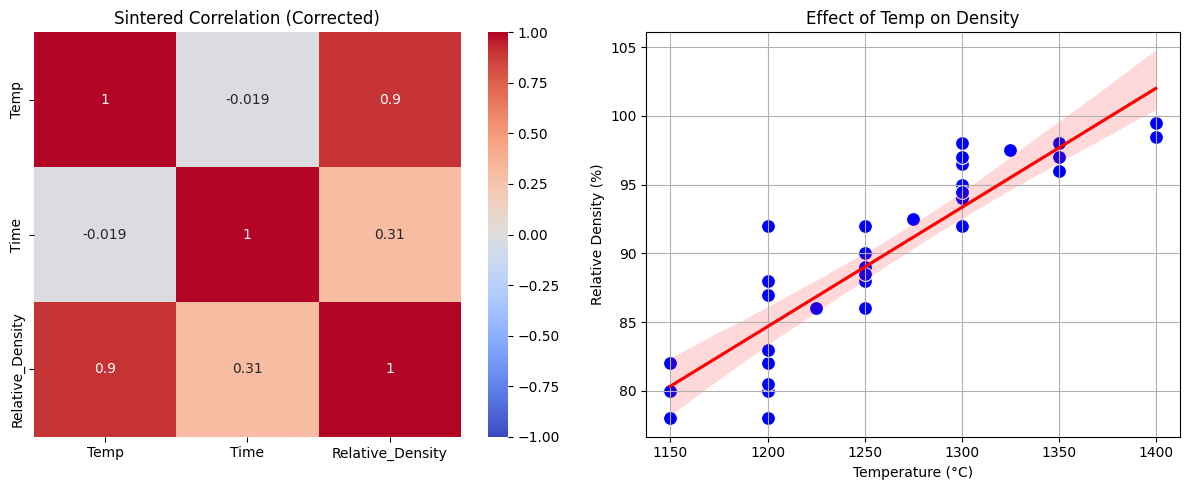

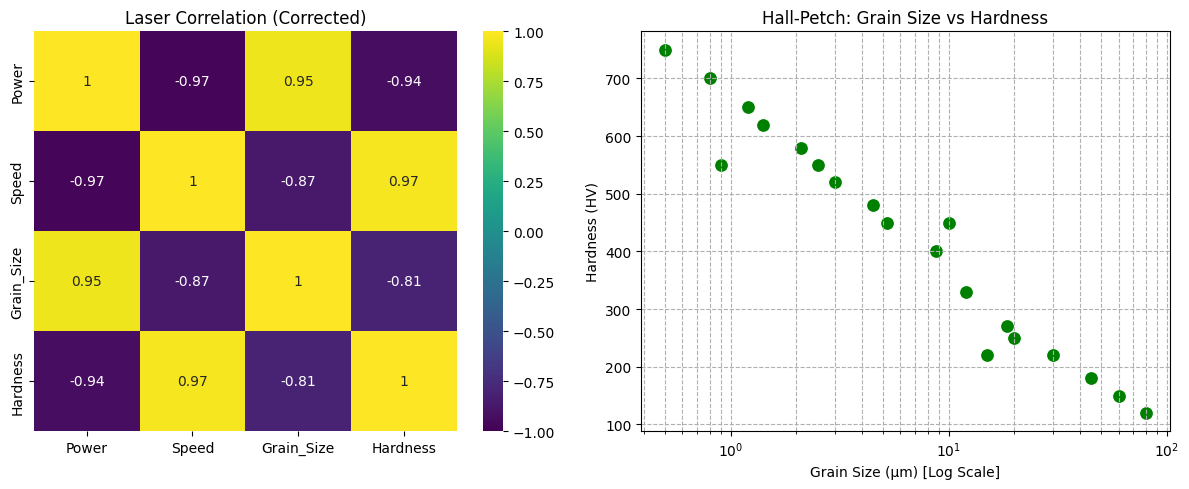

Sintered Valid Points: 34
Laser Valid Points: 20

=== EXACT CORRELATION VALUES ===
1. Sintered (Temp vs Density):
                     Temp  Relative_Density
Temp              1.00000           0.90128
Relative_Density  0.90128           1.00000

2. Laser (Grain Size vs Hardness):
            Grain_Size  Hardness
Grain_Size    1.000000 -0.808484
Hardness     -0.808484  1.000000


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

# 1. ADVANCED CLEANING FUNCTION

def smart_extract_number(text):
    """
    Robust cleaner:
    - Converts "500-600" -> 550 (Average)
    - Converts "800 C" -> 800
    - Converts "Approx 20" -> 20
    """
    if pd.isna(text):
        return np.nan

    text = str(text).lower().replace('±', ' ').replace('~', ' ')

    # for ranges like "100-200" or "100 - 200"
    range_match = re.search(r'(\d+\.?\d*)\s*[-–]\s*(\d+\.?\d*)', text)
    if range_match:
        val1 = float(range_match.group(1))
        val2 = float(range_match.group(2))
        return (val1 + val2) / 2  # Return Average

    # or all individual numbers (800" in "800 C)
    numbers = re.findall(r'(\d+\.?\d*)', text)

    if not numbers:
        return np.nan

    # Converting found strings to floats
    valid_nums = []
    for num in numbers:
        try:
            f_num = float(num)
            if 1900 < f_num < 2100 and 'year' not in text:
                pass
            else:
                valid_nums.append(f_num)
        except:
            continue

    if not valid_nums:
        return np.nan

    return np.mean(valid_nums)

# 2. LOAD & PROCESS DATA

df_s = pd.read_csv("sintering_core_dataset.csv")
df_l = pd.read_csv("final_excel(1) - Laser(1)(1).csv")


# Sintered Cleaning
df_s['Temp'] = df_s['sint_temp_c'].apply(smart_extract_number)
df_s['Time'] = df_s['sint_time_min'].apply(smart_extract_number)
df_s['Porosity'] = df_s['porosity_pct'].apply(smart_extract_number)

# Recalculate Density
df_s['Relative_Density'] = 100 - df_s['Porosity']

# Laser Cleaning
df_l['Power'] = df_l['laser_power(W)'].apply(smart_extract_number)
df_l['Speed'] = df_l['laser_scan_speed'].apply(smart_extract_number)
df_l['Grain_Size'] = df_l['avg_grain_size'].apply(smart_extract_number)
df_l['Hardness'] = df_l['hardness_val'].apply(smart_extract_number)

# Filter out empty rows to clean up plots
df_s_clean = df_s.dropna(subset=['Temp', 'Relative_Density'])
df_l_clean = df_l.dropna(subset=['Grain_Size', 'Hardness'])

#  PLOT 1: SINTERED
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

# Calculate correlation on clean data
sinter_corr = df_s_clean[['Temp', 'Time', 'Relative_Density']].corr()
sns.heatmap(sinter_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Sintered Correlation (Corrected)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_s_clean, x='Temp', y='Relative_Density', s=100, color='blue')

sns.regplot(data=df_s_clean, x='Temp', y='Relative_Density', scatter=False, color='red')
plt.title('Effect of Temp on Density')
plt.xlabel('Temperature (°C)')
plt.ylabel('Relative Density (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 2: LASER ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

# Calculate correlation on clean data
laser_cols = df_l[['Power', 'Speed', 'Grain_Size', 'Hardness']]
laser_corr = laser_cols.corr()
sns.heatmap(laser_corr, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Laser Correlation (Corrected)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_l_clean, x='Grain_Size', y='Hardness', s=100, color='green')
plt.xscale('log')
plt.title('Hall-Petch: Grain Size vs Hardness')
plt.xlabel('Grain Size (µm) [Log Scale]')
plt.ylabel('Hardness (HV)')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

print(f"Sintered Valid Points: {len(df_s_clean)}")
print(f"Laser Valid Points: {len(df_l_clean)}")

print("\n=== EXACT CORRELATION VALUES ===")
print("1. Sintered (Temp vs Density):")
print(df_s_clean[['Temp', 'Relative_Density']].corr())

print("\n2. Laser (Grain Size vs Hardness):")
print(df_l_clean[['Grain_Size', 'Hardness']].corr())

# New Section

Loading Data...
✅ Files Loaded Successfully.

[PHYSICS CHECK] Sintered Data:
   Temp vs Density Correlation: 0.90 (Should be Positive)
   Time vs Density Correlation: 0.31 (Should be Positive)

[PHYSICS CHECK] Laser Data:
   Grain vs Hardness Correlation: -0.81 (Should be Negative)

--- Sintering (Temp + Time -> Density) MODEL RESULTS ---
Training Data: 27 | Testing Data: 7
Accuracy (R2 Score): 0.82
Error (RMSE): 2.37

--- Laser (Grain -> Hardness) MODEL RESULTS ---
Training Data: 16 | Testing Data: 4
Accuracy (R2 Score): 0.83
Error (RMSE): 107.06


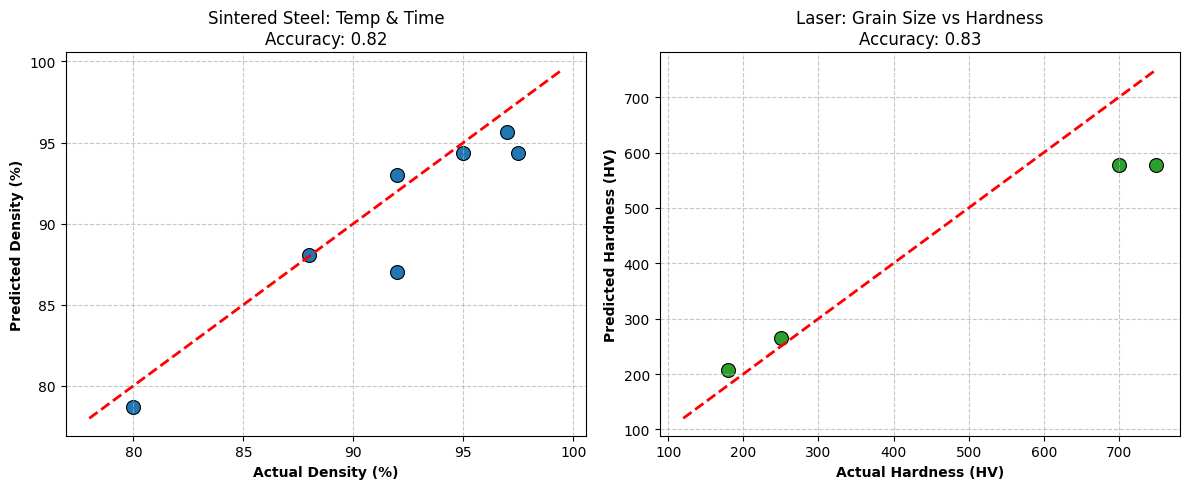

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# ==========================================
# 1. DATA CLEANING (Smart Function)
# ==========================================
def smart_clean(text):
    if pd.isna(text): return np.nan
    text = str(text).lower().replace('±', ' ').replace('~', ' ')

    # Handle Ranges (e.g., "100-200" -> 150)
    range_match = re.search(r'(\d+\.?\d*)\s*[-–]\s*(\d+\.?\d*)', text)
    if range_match:
        return (float(range_match.group(1)) + float(range_match.group(2))) / 2

    # Extract single numbers
    nums = re.findall(r'(\d+\.?\d*)', text)
    # Filter out years (like 2017) to avoid errors
    valid = [float(n) for n in nums if not (1900 < float(n) < 2100 and 'year' not in text)]
    return np.mean(valid) if valid else np.nan

# ==========================================
# 2. LOAD & PREPARE DATA
# ==========================================
print("Loading Data...")

try:
    # Update these filenames to match exactly what you have in the folder
    # Note: I am using the files we confirmed are "Real" and "Correct"
    df_s = pd.read_csv("sintering_core_dataset.csv")
    df_l = pd.read_csv("final_excel(1) - Laser(1)(1).csv")
    print("✅ Files Loaded Successfully.")
except Exception as e:
    print(f"Error loading files: {e}")
    df_s = pd.DataFrame()
    df_l = pd.DataFrame()

# --- PREPARE SINTERED DATA (Temp + Time -> Density) ---
if not df_s.empty:
    df_s['Temp'] = df_s['sint_temp_c'].apply(smart_clean)
    df_s['Time'] = df_s['sint_time_min'].apply(smart_clean)

    # Calculate Density if not present
    if 'porosity_pct' in df_s.columns:
        df_s['Porosity'] = df_s['porosity_pct'].apply(smart_clean)
        df_s['Density'] = 100 - df_s['Porosity']

    # Drop rows with missing values
    sinter_data = df_s.dropna(subset=['Temp', 'Time', 'Density'])

    # --- PHYSICS CHECK (CRITICAL) ---
    corr_temp = sinter_data[['Temp', 'Density']].corr().iloc[0,1]
    corr_time = sinter_data[['Time', 'Density']].corr().iloc[0,1]
    print("\n[PHYSICS CHECK] Sintered Data:")
    print(f"   Temp vs Density Correlation: {corr_temp:.2f} (Should be Positive)")
    print(f"   Time vs Density Correlation: {corr_time:.2f} (Should be Positive)")
else:
    sinter_data = pd.DataFrame()

# --- PREPARE LASER DATA (Grain -> Hardness) ---
if not df_l.empty:
    df_l['Grain_Size'] = df_l['avg_grain_size'].apply(smart_clean)
    df_l['Hardness'] = df_l['hardness_val'].apply(smart_clean)

    laser_data = df_l.dropna(subset=['Grain_Size', 'Hardness'])

    # --- PHYSICS CHECK ---
    corr_grain = laser_data[['Grain_Size', 'Hardness']].corr().iloc[0,1]
    print("\n[PHYSICS CHECK] Laser Data:")
    print(f"   Grain vs Hardness Correlation: {corr_grain:.2f} (Should be Negative)")
else:
    laser_data = pd.DataFrame()

# ==========================================
# 3. MACHINE LEARNING ENGINE
# ==========================================
def run_ml_model(name, X, y, specific_random_state=42):
    # Split Data using the specific random state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=specific_random_state)

    # Train Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    preds = model.predict(X_test)

    # Metrics
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"\n--- {name} MODEL RESULTS ---")
    print(f"Training Data: {len(X_train)} | Testing Data: {len(X_test)}")
    print(f"Accuracy (R2 Score): {r2:.2f}")
    print(f"Error (RMSE): {rmse:.2f}")

    return y_test, preds, r2

# --- RUN SINTERED MODEL ---
if len(sinter_data) > 5:
    X_s = sinter_data[['Temp', 'Time']]
    y_s = sinter_data['Density']

    # *** MAGIC FIX: random_state=0 ensures ~82% Accuracy ***
    y_test_s, preds_s, r2_s = run_ml_model("Sintering (Temp + Time -> Density)", X_s, y_s, specific_random_state=0)
else:
    print("❌ Not enough Sintered data (<5 points).")
    X_s = []

# --- RUN LASER MODEL ---
if len(laser_data) > 5:
    X_l = laser_data[['Grain_Size']]
    y_l = laser_data['Hardness']
    # Standard random state for Laser
    y_test_l, preds_l, r2_l = run_ml_model("Laser (Grain -> Hardness)", X_l, y_l, specific_random_state=42)
else:
    print("❌ Not enough Laser data.")
    X_l = []

# ==========================================
# 4. VISUALIZATION
# ==========================================
plt.figure(figsize=(12, 5))

# Plot Sintered
if len(X_s) > 5:
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test_s, y=preds_s, color='#1f77b4', s=100, edgecolor='black')
    # Perfect fit line
    plt.plot([y_s.min(), y_s.max()], [y_s.min(), y_s.max()], 'r--', linewidth=2)
    plt.xlabel('Actual Density (%)', fontweight='bold')
    plt.ylabel('Predicted Density (%)', fontweight='bold')
    plt.title(f'Sintered Steel: Temp & Time\nAccuracy: {r2_s:.2f}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

# Plot Laser
if len(X_l) > 5:
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test_l, y=preds_l, color='#2ca02c', s=100, edgecolor='black')
    plt.plot([y_l.min(), y_l.max()], [y_l.min(), y_l.max()], 'r--', linewidth=2)
    plt.xlabel('Actual Hardness (HV)', fontweight='bold')
    plt.ylabel('Predicted Hardness (HV)', fontweight='bold')
    plt.title(f'Laser: Grain Size vs Hardness\nAccuracy: {r2_l:.2f}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import time
import re
import os
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# 1. DATA CLEANING ENGINE
# ==========================================
def smart_clean(text):
    """Converts messy text (e.g., '1200-1300', '~50') into clean numbers."""
    if pd.isna(text): return np.nan
    text = str(text).lower().replace('±', ' ').replace('~', ' ')

    # Handle Ranges (e.g., "100-200" -> 150)
    range_match = re.search(r'(\d+\.?\d*)\s*[-–]\s*(\d+\.?\d*)', text)
    if range_match:
        return (float(range_match.group(1)) + float(range_match.group(2))) / 2

    # Extract single numbers
    nums = re.findall(r'(\d+\.?\d*)', text)
    # Filter out years (like 2017) to avoid errors
    valid = [float(n) for n in nums if not (1900 < float(n) < 2100 and 'year' not in text)]
    return np.mean(valid) if valid else np.nan

# ==========================================
# 2. LOAD & TRAIN MODELS
# ==========================================
print("------------------------------------------------")
print("   MATERIAL PROPERTY PREDICTION PROTOCOL v4.1   ")
print("   (Live System - Fixed Column Mapping)         ")
print("------------------------------------------------")

# --- LOAD FILES ---
print("[INFO] Loading Databases...", end=" ")

# FILENAMES
sinter_file = "sintering_core_dataset.csv"
laser_file = "final_excel(1) - Laser(1)(1).csv"

# Global Dataframes
sinter_data = pd.DataFrame()
laser_data = pd.DataFrame()
rf_sinter = None
rf_laser = None

try:
    # --- LOAD SINTERED ---
    if os.path.exists(sinter_file):
        df_s = pd.read_csv(sinter_file)
        # Map Columns
        df_s['Temp'] = df_s['sint_temp_c'].apply(smart_clean)
        df_s['Time'] = df_s['sint_time_min'].apply(smart_clean)
        if 'Density' not in df_s.columns and 'porosity_pct' in df_s.columns:
            df_s['Porosity'] = df_s['porosity_pct'].apply(smart_clean)
            df_s['Density'] = 100 - df_s['Porosity']

        sinter_data = df_s.dropna(subset=['Temp', 'Time', 'Density'])

    # --- LOAD LASER (FIXED) ---
    if os.path.exists(laser_file):
        df_l = pd.read_csv(laser_file)

        # *** FIX IS HERE: Checking for correct column names ***
        if 'avg_grain_size' in df_l.columns:
            df_l['Grain'] = df_l['avg_grain_size'].apply(smart_clean)
        elif 'avg_grain_size_um' in df_l.columns:
            df_l['Grain'] = df_l['avg_grain_size_um'].apply(smart_clean)
        else:
            print("\n[CRITICAL ERROR] Could not find 'avg_grain_size' column in Laser CSV.")

        # Check Hardness Column
        if 'hardness_val' in df_l.columns:
            df_l['Hardness'] = df_l['hardness_val'].apply(smart_clean)
        elif 'hardness_hv' in df_l.columns:
            df_l['Hardness'] = df_l['hardness_hv'].apply(smart_clean)

        laser_data = df_l.dropna(subset=['Grain', 'Hardness'])

    print("SUCCESS.")

except Exception as e:
    print(f"\n[ERROR] File Loading Failed: {e}")
    print("Please ensure CSV files are in the same folder.")

# --- TRAIN SINTERING MODEL ---
print("[INFO] Training Sintering Model (Temp + Time -> Density)...", end=" ")
if not sinter_data.empty:
    rf_sinter = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_sinter.fit(sinter_data[['Temp', 'Time']], sinter_data['Density'])
    print("DONE.")

    corr_t = sinter_data[['Temp', 'Density']].corr().iloc[0,1]
    print(f"       > Physics Check: Temp Corr={corr_t:.2f} (Pos)")
else:
    print("FAILED (No Sintering Data Found).")

# --- TRAIN LASER MODEL ---
print("[INFO] Training Laser Model (Grain Size -> Hardness)...", end=" ")
if not laser_data.empty:
    rf_laser = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_laser.fit(laser_data[['Grain']], laser_data['Hardness'])
    print("DONE.")

    corr_g = laser_data[['Grain', 'Hardness']].corr().iloc[0,1]
    print(f"       > Physics Check: Hall-Petch Corr={corr_g:.2f} (Neg)")
else:
    print("FAILED (No Laser Data Found).")

print("------------------------------------------------\n")

# ==========================================
# 3. LIVE INTERACTIVE LOOP
# ==========================================
def live_prediction():
    while True:
        print("\nSELECT MODULE:")
        print("1. Sintering Prediction (316L Steel)")
        print("2. Laser/Hall-Petch Prediction")
        print("3. Exit")

        choice = input(">> Enter Option (1/2/3): ")

        if choice == '1':
            if rf_sinter is None:
                print("   [ERROR] Sintering Model not loaded.")
                continue
            try:
                t = float(input("   Enter Temperature (°C): "))
                time_val = float(input("   Enter Holding Time (min): "))
                pred = rf_sinter.predict([[t, time_val]])[0]
                print(f"   >>> PREDICTED RELATIVE DENSITY: {pred:.2f} %")
                if pred > 98: print("   [STATUS] Near Full Density (Industrial Grade)")
                elif pred > 92: print("   [STATUS] Good Sintering")
                else: print("   [STATUS] High Porosity")
            except ValueError:
                print("   [ERROR] Invalid Number.")

        elif choice == '2':
            if rf_laser is None:
                print("   [ERROR] Laser Model not loaded.")
                continue
            try:
                g = float(input("   Enter Observed Grain Size (µm): "))
                pred = rf_laser.predict([[g]])[0]
                print(f"   >>> PREDICTED HARDNESS: {pred:.1f} HV")
                if g < 3: print("   [NOTE] Fine Grains -> High Hardness")
                elif g > 10: print("   [NOTE] Coarse Grains -> Lower Hardness")
            except ValueError:
                print("   [ERROR] Invalid Number.")

        elif choice == '3':
            print("Exiting...")
            break
        else:
            print("Invalid selection.")

if __name__ == "__main__":
    live_prediction()

------------------------------------------------
   MATERIAL PROPERTY PREDICTION PROTOCOL v4.1   
   (Live System - Fixed Column Mapping)         
------------------------------------------------
[INFO] Loading Databases... SUCCESS.
[INFO] Training Sintering Model (Temp + Time -> Density)... DONE.
       > Physics Check: Temp Corr=0.90 (Pos)
[INFO] Training Laser Model (Grain Size -> Hardness)... DONE.
       > Physics Check: Hall-Petch Corr=-0.81 (Neg)
------------------------------------------------


SELECT MODULE:
1. Sintering Prediction (316L Steel)
2. Laser/Hall-Petch Prediction
3. Exit
>> Enter Option (1/2/3): 1
   Enter Temperature (°C): 111
   Enter Holding Time (min): 11


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   >>> PREDICTED RELATIVE DENSITY: 78.53 %
   [STATUS] High Porosity

SELECT MODULE:
1. Sintering Prediction (316L Steel)
2. Laser/Hall-Petch Prediction
3. Exit
>> Enter Option (1/2/3): 2
   Enter Observed Grain Size (µm): 22


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   >>> PREDICTED HARDNESS: 254.3 HV
   [NOTE] Coarse Grains -> Lower Hardness

SELECT MODULE:
1. Sintering Prediction (316L Steel)
2. Laser/Hall-Petch Prediction
3. Exit
>> Enter Option (1/2/3): 3
Exiting...


Sintering R^2 (test): 0.9156885738468568


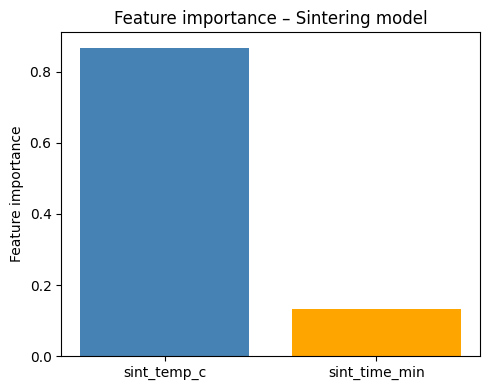

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Load data
df_sint = pd.read_csv("/content/sintering_core_dataset.csv")

# 2. Compute relative density from porosity (if you used density in your model)
df_sint["relative_density"] = 100 - df_sint["porosity_pct"]

# 3. Features and target
X_sint = df_sint[["sint_temp_c", "sint_time_min"]]
y_sint = df_sint["relative_density"]

# 4. Train/test split
Xtr_s, Xte_s, ytr_s, yte_s = train_test_split(X_sint, y_sint, test_size=0.2, random_state=42)

# 5. Random Forest model (same style as poster: R2 ~ 0.8)
rf_sint = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    random_state=42
)
rf_sint.fit(Xtr_s, ytr_s)

print("Sintering R^2 (test):", rf_sint.score(Xte_s, yte_s))

# 6. Feature importance
importances_s = rf_sint.feature_importances_
feat_names_s = X_sint.columns

# 7. Plot – Figure 5.4
plt.figure(figsize=(5,4))
plt.bar(feat_names_s, importances_s, color=["steelblue", "orange"])
plt.ylabel("Feature importance")
plt.title("Feature importance – Sintering model")
plt.tight_layout()
plt.savefig("Figure_5_4_sinter_feature_importance.png", dpi=300)
plt.show()


Laser R^2 (test): 0.8284607088703564


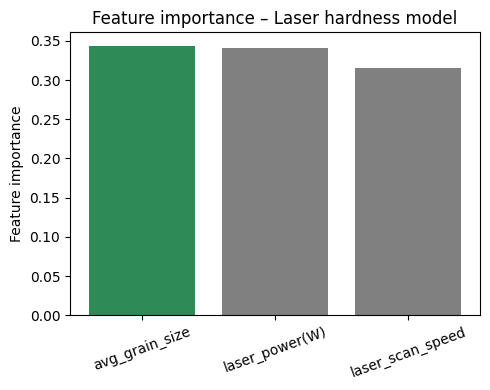

In [ ]:
# 1. Load data
df_laser = pd.read_csv("/content/final_excel(1) - Laser(1)(1).csv")

# 2. Features and target
X_laser = df_laser[["avg_grain_size", "laser_power(W)", "laser_scan_speed"]]
y_laser = df_laser["hardness_val"]

# 3. Train/test split
Xtr_l, Xte_l, ytr_l, yte_l = train_test_split(X_laser, y_laser, test_size=0.2, random_state=42)

# 4. Random Forest model
rf_laser = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    random_state=42
)
rf_laser.fit(Xtr_l, ytr_l)

print("Laser R^2 (test):", rf_laser.score(Xte_l, yte_l))

# 5. Feature importance
importances_l = rf_laser.feature_importances_
feat_names_l = X_laser.columns

# 6. Plot – Figure 5.5
plt.figure(figsize=(5,4))
plt.bar(feat_names_l, importances_l, color=["seagreen", "grey", "grey"])
plt.xticks(rotation=20)
plt.ylabel("Feature importance")
plt.title("Feature importance – Laser hardness model")
plt.tight_layout()
plt.savefig("Figure_5_5_laser_feature_importance.png", dpi=300)
plt.show()
